<a href="https://colab.research.google.com/github/mnishio240/laserscar/blob/main/%E7%B6%B2%E8%86%9C%E5%85%89%E5%87%9D%E5%9B%BA%E6%8B%A1%E5%A4%A7%E4%BA%88%E6%B8%AC%E3%82%B3%E3%83%BC%E3%83%89_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
# !pip install torch_optimizer

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torch
import torch.nn as nn
#import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image
from torch.cuda.amp import autocast, GradScaler


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-98b6c01c-9c8d-4ca5-138c-57b95ef30cbd)
Mounted at /content/drive


In [ ]:
#3人まとめて学習したコード
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import glob

# ✅ 設定
PX = 64
BATCH_SIZE = 256
EPOCHS = 300
PATIENCE = 30
NUM_FOLDS = 5

# ✅ ファイルパスの指定
csv_paths = [
    "/content/drive/MyDrive/Pixel_Comparison2YearsPatient1_Tracks_1_to_1004.csv",
    "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv",
    "/content/drive/MyDrive/Pixel_Comparison_Patient21R_0MPhoto_1Y3MPhoto.csv"
]

cropped_img_dirs = [
    "/content/drive/MyDrive/Patient_1_Cropped",
    "/content/drive/MyDrive/Patient13R_Cropped",
    "/content/drive/MyDrive/Patient21R_Cropped"
]

first_characters_list = ["pt1_2_0M", "Pt13R_2_0M", "Pt21R_2_0M"]

# ✅ 置換辞書（CSV のファイル名を画像フォルダに合わせるための変換）
replace_dict = {
    "pt1_2_0M_Photo": "pt1_5_1.5M_AF",
    "Pt13R_2_0M_Photo": "Pt13R_4_1MAF",
    "Pt21R_2_0M_Photo": "Pt21R_3_1M_AF"
}

# ✅ データの読み込みとフィルタリング（置換を適用して glob 検索を実行）
def load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list):
    all_data = []
    for csv_path, img_dir, first_characters in zip(csv_paths, cropped_img_dirs, first_characters_list):
        print(f"Processing: {csv_path}")
        df = pd.read_csv(csv_path)
        print(f"Initial DF size: {df.shape}")

        if df.empty:
            print(f"Warning: {csv_path} is empty!")
            continue

        if "File Prefix1" not in df.columns:
            print(f"Error: 'File Prefix1' column not found in {csv_path}")
            continue

        # 空白や改行を削除
        df["File Prefix1"] = df["File Prefix1"].str.strip()

        # contains() でフィルタリング（大文字小文字は区別せず）
        df = df[df["File Prefix1"].str.contains(first_characters, case=False, na=False)]
        print(f"Filtered DF size: {df.shape}")

        # --- ここで置換を適用（画像フォルダのファイル名に合わせるため） ---
        for key, value in replace_dict.items():
            df["File Prefix1"] = df["File Prefix1"].str.replace(key, value, regex=False)

        # glob.glob() の検索パターンを部分一致に変更
        # ※ CSV で指定された（置換済みの）ファイル名が、画像フォルダ内のファイル名の一部として存在する場合にヒットさせる
        df["Image Path"] = df["File Prefix1"].apply(lambda x: glob.glob(os.path.join(img_dir, "*" + x + "*")))
        df = df.explode("Image Path")
        print(f"After exploding: {df.shape}")

        df.dropna(subset=["Image Path"], inplace=True)
        print(f"Final DF size after dropping NaN: {df.shape}")

        all_data.append(df)

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

filtered_df = load_and_filter_data(csv_paths, cropped_img_dirs, first_characters_list)
filtered_df = filtered_df.reset_index(drop=True)

# ✅ 出力フォルダの作成
output_folder = "results226total"
os.makedirs(output_folder, exist_ok=True)

# ✅ データセット
class SimpleImageDataset(Dataset):
    def __init__(self, df, transform):
        self.transform = transform
        self.item_paths = df["Image Path"].tolist()
        self.ratio = df["Ratio"].values
        # ※ ここで再度置換を行う必要がある場合は追加してください

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        try:
            pil_image = Image.open(image_path).convert("RGB")
            tensor_image = self.transform(pil_image)
            target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
            return tensor_image, target
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return torch.utils.data.dataloader.default_collate(batch) if batch else (torch.empty(0), torch.empty(0))

# 画像前処理（学習時）
train_transforms = transforms.Compose([
    transforms.Resize((PX, PX)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 画像前処理（検証時）
val_transforms = transforms.Compose([
    transforms.Resize((PX, PX)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# サンプルのカスタムモデル（ResNet50 ベース、回帰出力）
class CustomResNet50(nn.Module):
    def __init__(self):
        super(CustomResNet50, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # 回帰用出力1つ

    def forward(self, x):
        return self.model(x)

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions, actuals = [], []
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    return total_loss / len(val_loader), np.array(predictions), np.array(actuals)

criterion = nn.MSELoss()


# ✅ Bland-Altman Plot

def bland_altman_plot(data1, data2):
    mean = (data1 + data2) / 2
    diff = data1 - data2
    plt.scatter(mean, diff, alpha=0.5)
    plt.axhline(np.mean(diff), color='gray', linestyle='--')
    plt.axhline(np.mean(diff) + 1.96 * np.std(diff), color='red', linestyle='--')
    plt.axhline(np.mean(diff) - 1.96 * np.std(diff), color='red', linestyle='--')
    plt.xlabel("Mean of Predicted and Actual")
    plt.ylabel("Difference (Predicted - Actual)")
    plt.title('Bland-Altman Plot')
    plt.grid()
    plt.show()

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(filtered_df)):
    print(f"Fold {fold+1}/{NUM_FOLDS}")
    train_dataset = SimpleImageDataset(filtered_df.iloc[train_idx], train_transforms)
    val_dataset = SimpleImageDataset(filtered_df.iloc[val_idx], val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = CustomResNet50().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_loss = float("inf")
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, predictions, actuals = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered")
                break

    errors = predictions - actuals
    result_df = pd.DataFrame({
        "Fold": fold + 1,
        "Predicted": predictions.flatten(),
        "Actual": actuals.flatten(),
        "Error": errors.flatten()
    })
    result_csv_path = os.path.join(output_folder, f"fold_{fold+1}_predictions.csv")
    result_df.to_csv(result_csv_path, index=False)
    print(f"Saved predictions to {result_csv_path}")

    bland_altman_plot(predictions, actuals)

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import KFold
import datetime

# ✅ 設定
PX = 64  # 画像サイズ
BATCH_SIZE = 64
PATIENCE = 30
EPOCHS = 300
NUM_FOLDS = 5
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

# ✅ タイムスタンプ付きフォルダ作成
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_folder = f"results_{timestamp}"
os.makedirs(output_folder, exist_ok=True)

# ✅ データ読み込みとフィルタリング
first_characters = "Pt13R_2_0M"
df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)].reset_index(drop=True)

# ✅ データセットの定義
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [
            os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M")
            for i in df["File Prefix1"]
        ]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        pil_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pil_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ 画像前処理
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.005),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_transforms = transforms.Compose([
    transforms.Resize((PX, PX)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ モデル定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return self.regressor(x)

# ✅ Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# ✅ 5-Fold Cross Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(filtered_df)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    train_subset = filtered_df.iloc[train_idx]
    val_subset = filtered_df.iloc[val_idx]

    train_dataset = SimpleImageDataset(cropped_img_dir, train_subset, train_transforms)
    val_dataset = SimpleImageDataset(cropped_img_dir, val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = LaserSpotResNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=EPOCHS * len(train_loader))
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=1e-4)

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()

        if early_stopping(running_loss, model):
            print("Early stopping triggered")
            break

    model.load_state_dict(early_stopping.best_model)
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy().flatten())

    val_subset = val_subset.copy()
    val_subset["Prediction"] = predictions
    val_subset.to_csv(f"{output_folder}/predictions_fold_{fold+1}.csv", index=False)
    all_predictions.append(val_subset)

print("\n✅ 5-Fold Cross Validation Complete!")



===== Fold 1/5 =====


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Early stopping triggered

===== Fold 2/5 =====


KeyboardInterrupt: 

In [ ]:
#修正後
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import KFold
import datetime

# ✅ 設定
PX = 64
BATCH_SIZE = 64
PATIENCE = 30
EPOCHS = 300
NUM_FOLDS = 5
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

# ✅ タイムスタンプ付きフォルダ作成
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_folder = f"results_{timestamp}"
os.makedirs(output_folder, exist_ok=True)

# ✅ データ読み込みとフィルタリング
first_characters = "Pt13R_2_0M"
df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith(first_characters)].reset_index(drop=True)

# ✅ データセットの定義
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [
            os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M")
            for i in df["File Prefix1"]
        ]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        pil_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pil_image)
        target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
        return tensor_image, target

# ✅ 画像前処理
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.005),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_transforms = transforms.Compose([
    transforms.Resize((PX, PX)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ モデル定義
class LaserSpotResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return self.regressor(x)

# ✅ Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# ✅ 5-Fold Cross Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(filtered_df)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    train_subset = filtered_df.iloc[train_idx]
    val_subset = filtered_df.iloc[val_idx]

    train_dataset = SimpleImageDataset(cropped_img_dir, train_subset, train_transforms)
    val_dataset = SimpleImageDataset(cropped_img_dir, val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = LaserSpotResNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=EPOCHS * len(train_loader))
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=1e-4)

    train_losses = []
    val_losses = []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if early_stopping(avg_train_loss, model):
            print("Early stopping triggered")
            break

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{output_folder}/loss_curve_fold_{fold+1}.png")
    plt.close()

print("\n✅ 5-Fold Cross Validation Complete!")


===== Fold 1/5 =====


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]



===== Fold 2/5 =====
Early stopping triggered

===== Fold 3/5 =====
Early stopping triggered

===== Fold 4/5 =====
Early stopping triggered

===== Fold 5/5 =====
Early stopping triggered

✅ 5-Fold Cross Validation Complete!



===== Fold 1/5 =====
Fold 1, Epoch 1, Train Loss: 1.4260
Fold 1, Epoch 1, Val Loss: 0.6882
Fold 1, Epoch 2, Train Loss: 1.4097
Fold 1, Epoch 2, Val Loss: 0.7112
Fold 1, Epoch 3, Train Loss: 1.3922
Fold 1, Epoch 3, Val Loss: 0.7287
Fold 1, Epoch 4, Train Loss: 1.3756
Fold 1, Epoch 4, Val Loss: 0.7596
Fold 1, Epoch 5, Train Loss: 1.3781
Fold 1, Epoch 5, Val Loss: 0.7906
Fold 1, Epoch 6, Train Loss: 1.3516
Fold 1, Epoch 6, Val Loss: 0.8075
Fold 1, Epoch 7, Train Loss: 1.3502
Fold 1, Epoch 7, Val Loss: 0.8224
Fold 1, Epoch 8, Train Loss: 1.3428
Fold 1, Epoch 8, Val Loss: 0.8426
Fold 1, Epoch 9, Train Loss: 1.3060
Fold 1, Epoch 9, Val Loss: 0.8838
Fold 1, Epoch 10, Train Loss: 1.3060
Fold 1, Epoch 10, Val Loss: 0.9483
Fold 1, Epoch 11, Train Loss: 1.2725
Fold 1, Epoch 11, Val Loss: 1.0171
Fold 1, Epoch 12, Train Loss: 1.2430
Fold 1, Epoch 12, Val Loss: 1.1087
Fold 1, Epoch 13, Train Loss: 1.2207
Fold 1, Epoch 13, Val Loss: 1.2039
Fold 1, Epoch 14, Train Loss: 1.1932
Fold 1, Epoch 14, Val L

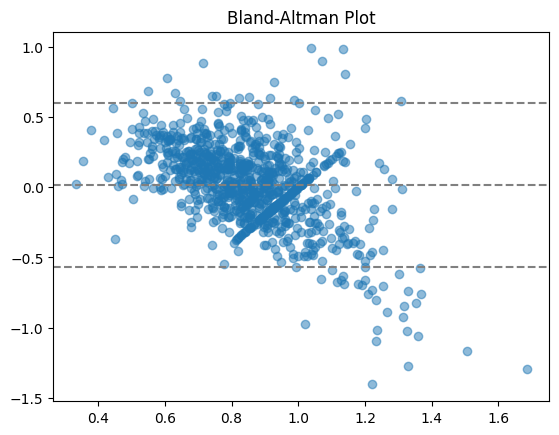

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# ✅ 設定
PX = 64
BATCH_SIZE = 256
EPOCHS = 300
PATIENCE = 30
NUM_FOLDS = 5
csv_path = "/content/drive/MyDrive/Pixel_Comparison2Y3MPatient13R_Tracks_1_to_1010.csv"
cropped_img_dir = "/content/drive/MyDrive/Patient13R_Cropped"

# ✅ 出力フォルダの作成
output_folder = "results226"
os.makedirs(output_folder, exist_ok=True)

# ✅ データ読み込み
df = pd.read_csv(csv_path)
filtered_df = df[df["File Prefix1"].str.startswith("Pt13R_2_0M")].reset_index(drop=True)

# ✅ データセット
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, df, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = [os.path.join(self.folder_path, i).replace("Photo", "AF").replace("_2_0M", "_4_1M") for i in df["File Prefix1"]]
        self.ratio = df["Ratio"].values

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        try:
            pil_image = Image.open(image_path).convert("RGB")
            tensor_image = self.transform(pil_image)
            target = torch.tensor([self.ratio[idx]], dtype=torch.float32)
            return tensor_image, target
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None

# ✅ DataLoader の collate 関数
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return []
    return torch.utils.data.dataloader.default_collate(batch)

# ✅ 画像前処理
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(PX, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.005),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

val_transforms = transforms.Compose([
    transforms.Resize((PX, PX)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

# ✅ カスタム ResNet50
class CustomResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.resnet.maxpool = nn.Identity()
        self.resnet.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.resnet.fc = nn.Identity()

        self.regressor = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        return self.regressor(x)

# ✅ Early Stopping
class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None

    def __call__(self, loss, model):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1

        return self.counter >= self.patience
# ✅ 5-Fold Cross Validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(filtered_df)):
    print(f"\n===== Fold {fold+1}/{NUM_FOLDS} =====")

    train_dataset = SimpleImageDataset(cropped_img_dir, filtered_df.iloc[train_idx], train_transforms)
    val_dataset = SimpleImageDataset(cropped_img_dir, filtered_df.iloc[val_idx], val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = CustomResNet50().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=0.3, anneal_strategy="cos")

    early_stopping = EarlyStopping()

    # ✅ 学習ループ
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

        # ✅ 検証
        model.eval()
        val_loss = 0.0
        predictions, actuals = [], []
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                predictions.extend(outputs.cpu().numpy().flatten())
                actuals.extend(targets.cpu().numpy().flatten())

        val_loss /= len(val_loader)
        print(f"Fold {fold+1}, Epoch {epoch+1}, Val Loss: {val_loss:.4f}")

        # ✅ Early Stopping
        if early_stopping(val_loss, model):
            print("Early stopping triggered")
            break

    # ✅ 予測結果の保存
    fold_predictions = pd.DataFrame({
        "Predicted": predictions,
        "Actual": actuals,
        "Fold": fold+1
    })
    all_predictions.append(fold_predictions)

# ✅ 全Foldの結果を統合
all_predictions_df = pd.concat(all_predictions, ignore_index=True)
all_predictions_df.to_csv(os.path.join(output_folder, "all_predictions.csv"), index=False)

# ✅ Bland-Altman Plot 修正
def bland_altman_plot(data1, data2):
    mean = (data1 + data2) / 2
    diff = data1 - data2
    mean_diff = np.mean(diff)
    std_diff = np.std(diff, ddof=1)

    plt.scatter(mean, diff, alpha=0.5)
    plt.axhline(mean_diff, color='gray', linestyle='--')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')

plt.figure()
bland_altman_plot(all_predictions_df["Predicted"], all_predictions_df["Actual"])
plt.title('Bland-Altman Plot')
plt.savefig(os.path.join(output_folder, 'bland_altman_plot.png'))

print("\n✅ 5-Fold Cross Validation Complete!")